In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [232]:
class DecisionTreeClassifier:
    class Node:
        def __init__(self, feature=None, value=None, children=None):
            self.feature = feature
            self.value = value
            self.children = children or {}

    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.selected_features = None

    def _entropy(self, y):
        counter = Counter(y)
        probs = [count / len(y) for count in counter.values()]
        return -sum(p * np.log2(p) for p in probs)

    def _information_gain(self, X, y, feature):
        total_entropy = self._entropy(y)

        feature_values = X[feature].value_counts()
        weighted_entropy = 0
        
        for value in feature_values.index:
            mask = X[feature] == value
            subset_y = y[mask]
            weight = len(subset_y) / len(y)
            weighted_entropy += weight * self._entropy(subset_y)
        
        return total_entropy - weighted_entropy

    def _handle_missing_values(self, X):
        X = X.copy()
        for column in X.columns:
            X[column] = X[column].fillna(X[column].mode()[0])
        return X

    def _select_random_features(self, features):
        n = int(np.sqrt(len(features)))
        return np.random.choice(features, size=n, replace=False)

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_labels = len(np.unique(y))

        # Проверка условий остановки
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or n_labels == 1:
            return self.Node(value=Counter(y).most_common(1)[0][0])

        best_feature = None
        best_gain = -1

        for feature in X.columns:
            gain = self._information_gain(X, y, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

        if best_gain == -1:
            return self.Node(value=Counter(y).most_common(1)[0][0])

        children = {}
        unique_values = X[best_feature].unique()
        
        for value in unique_values:
            mask = X[best_feature] == value
            if mask.any():
                child_X = X[mask].drop(columns=[best_feature])
                child_y = y[mask]
                children[value] = self._build_tree(child_X, child_y, depth + 1)

        return self.Node(feature=best_feature, children=children)

    def fit(self, X, y):
        X = self._handle_missing_values(X)
        
        self.selected_features = self._select_random_features(X.columns)
        X = X[self.selected_features]
        
        self.root = self._build_tree(X, y)
        return self

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        feature_value = x[node.feature]
        if feature_value in node.children:
            return self._predict_one(x, node.children[feature_value])
        else:
            predictions = [child.value for child in node.children.values() 
                         if child.value is not None]
            return Counter(predictions).most_common(1)[0][0]

    def predict(self, X):
        X = self._handle_missing_values(X)
        X = X[self.selected_features]
        return np.array([self._predict_one(x, self.root) 
                        for _, x in X.iterrows()])

    def evaluate(self, X_test, y_test):    
        y_pred = self.predict(X_test)
        
        tp = np.sum((y_test == 'p') & (y_pred == 'p'))
        tn = np.sum((y_test == 'e') & (y_pred == 'e'))
        fp = np.sum((y_test == 'e') & (y_pred == 'p'))
        fn = np.sum((y_test == 'p') & (y_pred == 'e'))
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        
    
        
        sns.set(font_scale=1.5)
        sns.set_color_codes("muted")
        plt.figure(figsize=(10, 8))
        
        plt.plot([0, fpr,1], [0, tpr,1], lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()
        
        
        
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        
        thresholds = [i/100 for i in range(100)]
        precision, recall = [], []
        
        y_pred_proba = np.array([1 if pred == 'p' else 0 for pred in y_pred])
        y_true = np.array([1 if true == 'p' else 0 for true in y_test])
        
        for threshold in thresholds:
            y_pred_th = (y_pred_proba >= threshold).astype(int)
            tp = np.sum((y_true == 1) & (y_pred_th == 1))
            fp = np.sum((y_true == 0) & (y_pred_th == 1))
            fn = np.sum((y_true == 1) & (y_pred_th == 0))
            recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
            precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        recall.append(0)
        precision.append(1)
       
        plt.clf()
        plt.plot(recall, precision)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.legend(loc="lower right")
            
            
        plt.show()
        
        


In [233]:
data = pd.read_csv('./agaricus-lepiota.data', header=None)
data = data.replace('?', np.nan)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [234]:
X = data.drop(0, axis=1)
y = data[0]

In [235]:
from sklearn.model_selection import train_test_split

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2)

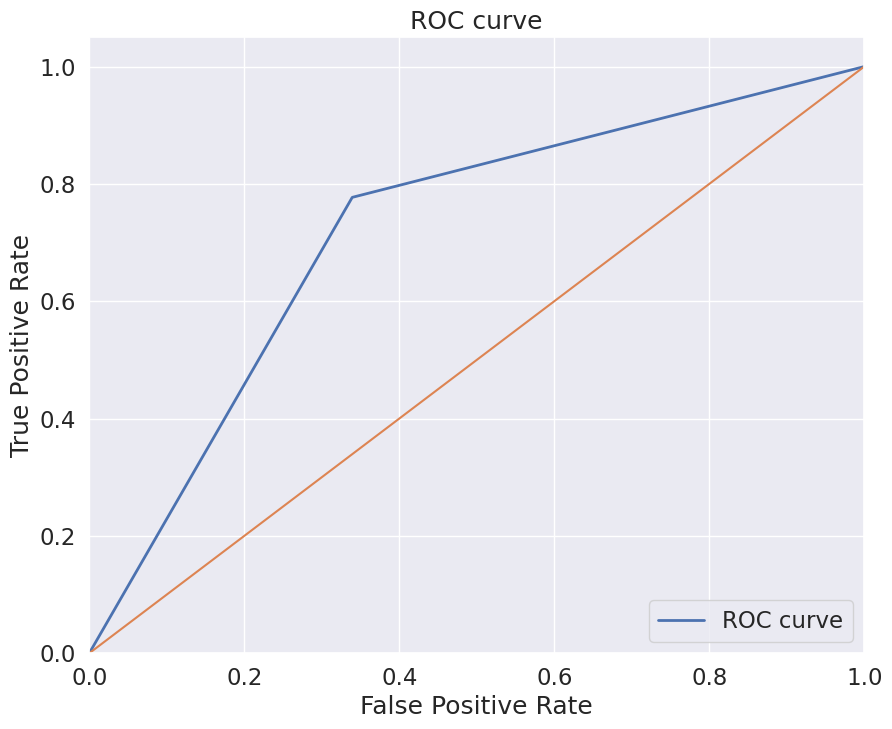

Accuracy: 0.7175
Precision: 0.6863
Recall: 0.7771


/tmp/ipykernel_7580/3214166333.py:173: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


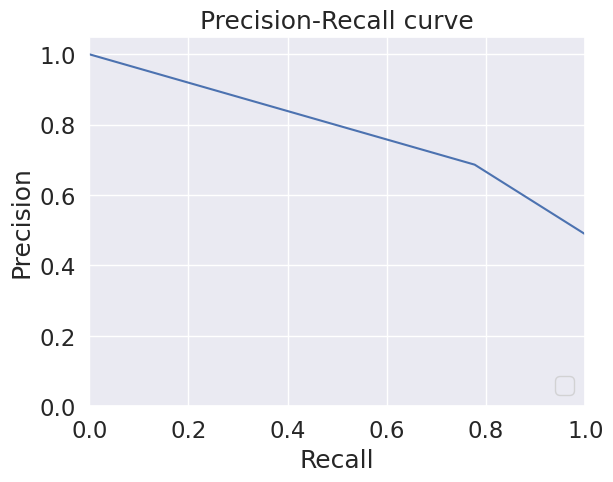

In [237]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train)

tree.evaluate(X_test, y_test)

